Some good transfer style tutorials:

https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398

https://towardsdatascience.com/neural-style-transfer-tutorial-part-1-f5cd3315fa7f

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/15_Style_Transfer.ipynb![image.png](attachment:image.png)

Below is mainly based on the TF tutorial.

Github for 3D style transfer: https://github.com/hiroharu-kato/style_transfer_3d/blob/master/style_transfer_3d/main.py

**Issues/Tasks:**
1. need to scale the image to 0-1?
2. need to subtract the mean style when calculate style loss?
3. add back print and save functions for 3D
4. OOM!!

## Environment Setup

In [1]:
import os, time, itertools
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure


# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import PIL.Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(0)
tf.set_random_seed(0)

tf.__version__

'1.12.0'

## Import Data

In [2]:
# import data
import env
from data.thingi10k import Thingi10k
from data.stl import save_vectors_as_stl
from data.stl import plot_mesh
from data.voxels import plot_voxels

# thingi = Thingi10k.init10()
# n_samples = len(thingi)
# n_samples

thingi = Thingi10k.init10k(pctile=.8)
# apply filter
thingi.filter_by_tag('animal')
n_input = len(thingi)
n_input

109

In [3]:
output_dir = os.path.join('_output', 'style_transfer')
os.makedirs(output_dir, exist_ok=True)
graphs_dir = os.path.join(output_dir, 'graphs')
os.makedirs(graphs_dir, exist_ok=True)
model_dir = os.path.join(output_dir, 'model')
os.makedirs(model_dir, exist_ok=True)

## VGG-16 Model

In [4]:
import vgg16
# # download the data if not loaded, it's 550MB!!
vgg16.data_dir = 'vgg16/'
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


In [5]:
## image helper functions

def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, PIL.Image.LANCZOS)

    # Convert to numpy floating-point array.
    return np.float32(image)


def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')
        
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))
    
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [6]:
## Loss functions

def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

def create_content_loss(session, model, content_image, layer_ids):
    """
    Create the loss-function for the content-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    content_image: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. Wrap it to ensure it
            # is a const - although this may be done
            # automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

def gram_matrix(tensor):
    shape = tensor.get_shape()
       
#     mean = np.array([103.939, 116.779, 123.68], 'float32')  # BGR

    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])


    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
#     matrix = tf.reshape(tensor, shape=[-1, num_channels])
    matrix = tf.contrib.layers.flatten(tensor)
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram

def create_style_loss(session, model, style_image, layer_ids):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image) # 4-d dimension

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:])) + \
            tf.reduce_sum(tf.abs(model.input[:,:,:,1:] - model.input[:,:,:,:-1]))

    return loss

In [7]:
## style-transfer algorithm
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
    """

    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image.
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    mixed_image = np.random.rand(*content_image.shape) # voxel should be 0 or 1!!

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
#         mixed_image = np.clip(mixed_image, 0.0, 255.0)
        mixed_image = np.clip(mixed_image, 0.0, 1.0) # should just assign 0 or 1?

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

#             # Plot the content-, style- and mixed-images.
#             plot_images(content_image=content_image,
#                         style_image=style_image,
#                         mixed_image=mixed_image)
            try:
            
#                 dim = 64
#                 vox_vectors = np.reshape(mixed_image, (dim, dim, dim))

                ckpt_dir = os.path.join(model_dir, 'epoch_{}'.format(i))
                os.makedirs(ckpt_dir, exist_ok=True)

                np_path = os.path.join(ckpt_dir, 'epoch_{}.npy'.format(i))
                np.save(np_path, mixed_image)

#                 # Use marching cubes to obtain the surface mesh
#                 verts, faces, normals, values = measure.marching_cubes_lewiner(vox_vectors, 0)
#                 save_vectors_as_stl(verts[faces], os.path.join(ckpt_dir, 'epoch_{}.stl'.format(i)))
#                 plot_mesh(verts[faces])
                plot_voxels(mixed_image)
            except Exception as exc:
                print('Model generation failed for this epoch')
                print(exc)
#     print()
#     print("Final image:")
#     plot_image_big(mixed_image)
    

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

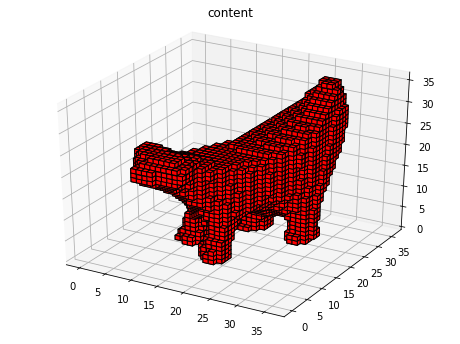

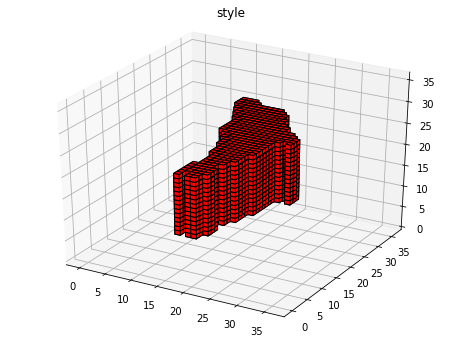

content shape:  (1, 36, 36, 36)
style shape:  (1, 36, 36, 36)


In [11]:
## example
# content_filename = 'images/willy_wonka_old.jpg'
# content_image = load_image(content_filename, max_size=None)
voxel_size = 36 # why need to be evenly divided by 3?
## assuming both content and style input are 3D
for batch_num, batch in enumerate(thingi.voxels_batchmaker(batch_size=2, voxels_dim=voxel_size)):
    content_image = np.reshape(batch[0],(voxel_size, voxel_size, voxel_size))
    plot_voxels(content_image, title="content")
    content_image = np.expand_dims(content_image, axis=0)
    style_image = np.reshape(batch[1],(voxel_size, voxel_size, voxel_size))
    plot_voxels(style_image, title="style")
    style_image = np.expand_dims(style_image, axis=0)
    break
# style_filename = 'images/style7.jpg'
# style_image = load_image(style_filename, max_size=300)
# style_image = np.expand_dims(style_image, axis=0)
print("content shape: ", content_image.shape)
print("style shape: ", style_image.shape)



In [9]:
# # use average style color for content input as background?
# mean = style_image.mean((0, 1, 2))/255.0
# # print(mean)
# content_image = np.expand_dims(content_image, axis=3)
# content_image = content_image + mean[None, None, None, :]
# print("content shape: ", content_image.shape)
# print("style shape: ", style_image.shape)

In [13]:
content_layer_ids = [4]

# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
# style_layer_ids = list(range(13))

# You can also select a sub-set of the layers, e.g. like this:
style_layer_ids = [1, 2, 3, 4]

In [14]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=10.0)

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2']



UnimplementedError: Generic conv implementation does not support grouped convolutions for now.
	 [[node conv1_1/Conv2D (defined at C:\Users\cynth\desktop\3d-form\notebooks\vgg16.py:116)  = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](concat, conv1_1/filter)]]

Caused by op 'conv1_1/Conv2D', defined at:
  File "C:\Users\cynth\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\cynth\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\cynth\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\cynth\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\cynth\Anaconda3\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\cynth\Anaconda3\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\cynth\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\cynth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-087e8c82af4c>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', 'img = style_transfer(content_image=content_image,\n                     style_image=style_image,\n                     content_layer_ids=content_layer_ids,\n                     style_layer_ids=style_layer_ids,\n                     weight_content=1.5,\n                     weight_style=10.0,\n                     weight_denoise=0.3,\n                     num_iterations=60,\n                     step_size=10.0)\n')
  File "C:\Users\cynth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2323, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<C:\Users\cynth\Anaconda3\lib\site-packages\decorator.py:decorator-gen-63>", line 2, in time
  File "C:\Users\cynth\Anaconda3\lib\site-packages\IPython\core\magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\IPython\core\magics\execution.py", line 1271, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 9, in <module>
  File "<ipython-input-7-4469b564ce9f>", line 30, in style_transfer
    model = vgg16.VGG16()
  File "C:\Users\cynth\desktop\3d-form\notebooks\vgg16.py", line 116, in __init__
    tf.import_graph_def(graph_def, name='')
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tensorflow\python\framework\importer.py", line 442, in import_graph_def
    _ProcessNewOps(graph)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tensorflow\python\framework\importer.py", line 234, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3440, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3440, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3299, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "C:\Users\cynth\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

UnimplementedError (see above for traceback): Generic conv implementation does not support grouped convolutions for now.
	 [[node conv1_1/Conv2D (defined at C:\Users\cynth\desktop\3d-form\notebooks\vgg16.py:116)  = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](concat, conv1_1/filter)]]
